In [ ]:
# Import required libraries
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [ ]:
# Connect to SQLite database
engine = create_engine('sqlite:///engine.db')

In [ ]:
# reading the training dataset
training_dataset = pd.read_csv('dataset//train.csv')

# loading into db
training_dataset.to_sql('training_data', engine, if_exists='replace', index=False)

In [ ]:
# reading the 50 ideal functions
ideal_functions = pd.read_csv('dataset//ideal.csv')

# loading into db
ideal_functions.to_sql('ideal_functions', engine, if_exists='replace', index=False)

In [ ]:
def select_best_functions(engine, n_functions=4):
    """
    Selects the best n_functions ideal functions that minimize the sum of y-deviations squared (Least-Square).
    """

    # Read the training data and the ideal functions from the db
    training_data = pd.read_sql_query('SELECT * FROM training_data', engine)
    ideal_functions = pd.read_sql_query('SELECT * FROM ideal_functions', engine)

    # Initialize a dictionary to store the best functions for each training function
    best_functions = {}
    # This will hold the maximum deviations for each training function
    max_deviations = {}  

    # For each training function
    for training_func in ['y1', 'y2', 'y3', 'y4']:
        # Initialize a dictionary to store the sum of squared differences for each ideal function
        SSDs = {}

        # For each ideal function
        for ideal_func in ideal_functions.columns[1:]:
            # Calculate the sum of squared differences for the current function
            SSDs[ideal_func] = ((ideal_functions[ideal_func] - training_data[training_func]) ** 2).sum()

        # Sort the functions by their sum of squared differences
        sorted_SSDs = sorted(SSDs.items(), key=lambda x: x[1])

        # Select the best function
        best_function, min_SSD = sorted_SSDs[0]

        # Store the best function and the maximum deviation (sqrt of min_SSD) for the current training function
        best_functions[training_func] = best_function
        # Take the square root to get the RMSD
        max_deviations[training_func] = min_SSD ** 0.5  

    # Return the best functions and the maximum deviations
    return best_functions, max_deviations

# Call the function to select the best functions
best_functions, max_deviations = select_best_functions(engine)

print("Best functions: ", best_functions, max_deviations)


In [ ]:
def assign_test_data(engine, best_functions, max_deviations):
    """
    Assigns the test data to the best fitting ideal function based on deviation.
    Saves the results to a SQLite database.
    """
    # Define the maximum deviation factor
    max_deviation_factor = np.sqrt(2)

    # Read the ideal functions data
    ideal_functions = pd.read_sql_query('SELECT * FROM ideal_functions', engine)

    # Initialize an empty dataframe to store the results
    results = pd.DataFrame(columns=['X', 'Y', 'Delta_Y', 'Ideal_Func'])

    # Read the test data from CSV file
    test_data = pd.read_csv('dataset//test.csv')

    # Iterate over each row in the test data
    for index, row in test_data.iterrows():
        # Initialize the smallest deviation and the best function
        smallest_deviation = float('inf')
        best_func = None

        # Iterate over each of the best functions
        for func_name, ideal_func in best_functions.items():
            # Calculate the deviation of the y-value from the current ideal function
            deviation = abs(row['y'] - ideal_functions[ideal_func][index])

            # If the deviation is within the acceptable range and it's less than the current smallest deviation
            if deviation <= max_deviation_factor * max_deviations[func_name] and deviation < smallest_deviation:
                # Update the largest deviation and the best function
                smallest_deviation = deviation
                best_func = ideal_func
                    
        if best_func is not None:
            # Add the test case to the results dataframe
            results.loc[index] = [row['x'], row['y'], smallest_deviation, best_func]
        else:
            # Add the test case to the results dataframe, but with '/' for deviation and function
            results.loc[index] = [row['x'], row['y'], "/", "/"]


    # Save the results to the SQLite database
    results.to_sql('test_data_results', engine, if_exists='replace', index=False)



assign_test_data(engine, best_functions, max_deviations)

testing_data = pd.read_sql_query('SELECT * FROM test_data_results', engine)

print (testing_data)

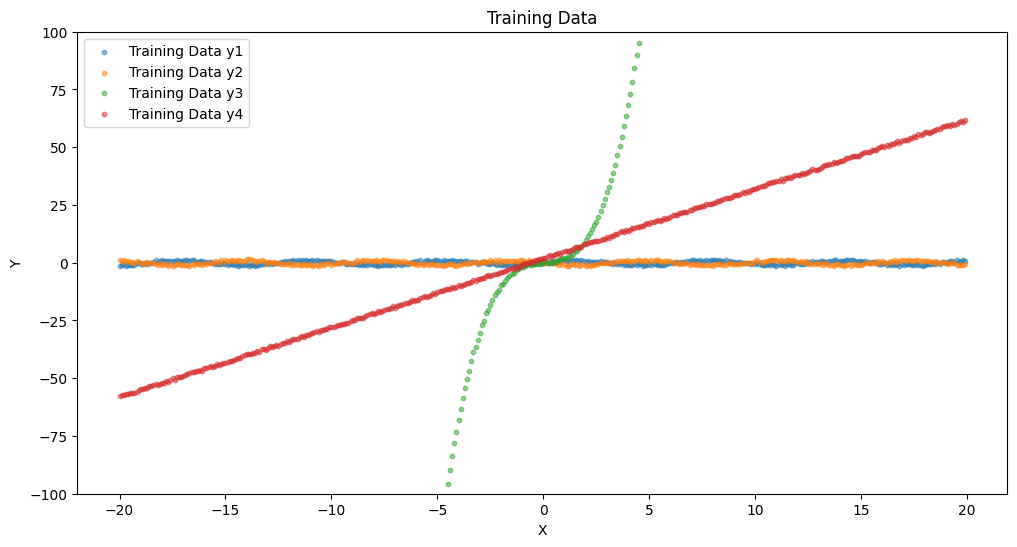

In [126]:
import matplotlib.pyplot as plt

def visualize_training_data(training_data, y_min=None, y_max=None):
    """
    Visualize the training data.

    Parameters:
    - training_data: DataFrame containing training data
    - y_min: Optional. The minimum y-value to include in the plot
    - y_max: Optional. The maximum y-value to include in the plot
    """

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot training data
    for col in training_data.columns[1:]:
        plt.scatter(training_data['x'], training_data[col], label=f'Training Data {col}', s=10, alpha=0.5)

    # Set y-axis limits, if specified
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)

    # Add labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Training Data')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()


    
training_data = pd.read_sql_query('SELECT * FROM training_data', engine)   
#print (training_data)
ideal_functions = pd.read_sql_query('SELECT * FROM ideal_functions', engine)



visualize_training_data(training_dataset, y_min=-100, y_max=100)


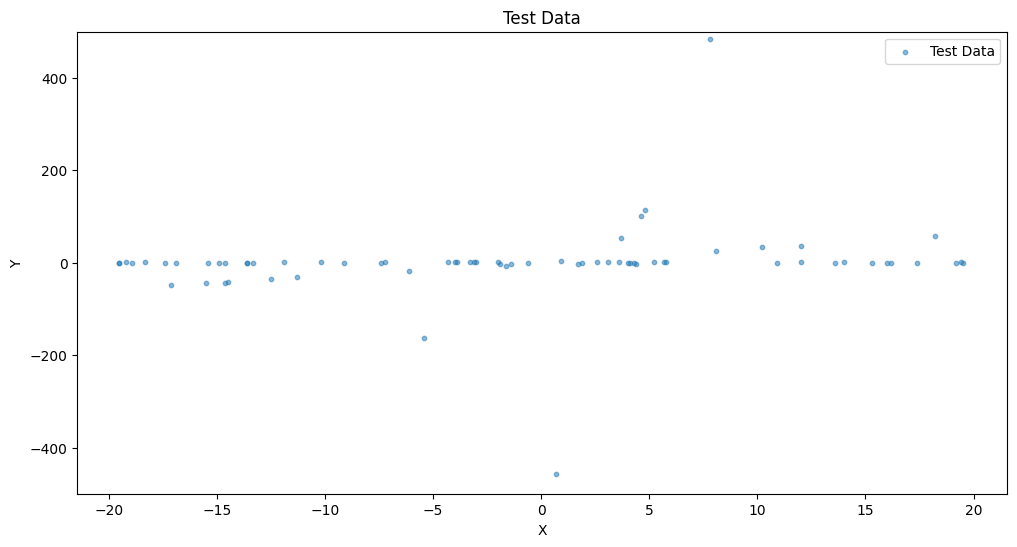

In [128]:
def visualize_test_data(test_data, y_min=None, y_max=None):
    """
    Visualize the test data.

    Parameters:
    - test_data: DataFrame containing test data
    - y_min: Optional. The minimum y-value to include in the plot
    - y_max: Optional. The maximum y-value to include in the plot
    """

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot test data
    plt.scatter(test_data['x'], test_data['y'], label='Test Data', s=10, alpha=0.5)

    # Set y-axis limits, if specified
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)

    # Add labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Test Data')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()
    
test_data = pd.read_csv('dataset//test.csv')
visualize_test_data(test_data, y_min=-500, y_max=+500)